In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image, ImageFile
import tensorflow as tf
import json
import glob
import random
import pathlib
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet121

import gradio as gr
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [10]:
# Paths to the dataset
dataset_path = "/content/train"
train_data_dir = pathlib.Path(dataset_path + "/images")
test_data_dir = pathlib.Path("/content/test/images")

In [11]:
# Prepare training and testing datasets
train_files = glob.glob(r"" + dataset_path + "/images/*.png")
train_files = list(filter(lambda x: "post" in x, train_files))
train_files = random.sample(train_files, 1500)
train_datasize = len(train_files)
print("Training data:", train_datasize)

test_files = glob.glob(r"" + "/content/test/images/*.png")
test_files = list(filter(lambda x: "post" in x, test_files))
test_files = random.sample(test_files, 500)
test_datasize = len(test_files)
print("Test data:", test_datasize)

Training data: 1500
Test data: 500


In [12]:
# Image dimensions
img_height = 1024
img_width = 1024
class_names = np.array(['no damage', 'minor damage', 'major damage', 'destroyed'])
print(class_names)

['no damage' 'minor damage' 'major damage' 'destroyed']


In [13]:
# Label extraction function
def get_label(file_path, type):
    parts = file_path.split(os.path.sep)

    # Define path for test labels
    path = dataset_path+'/labels/'
    if type == "test":
        path = '/content/test/labels/'
    f = open(path + parts[-1].split('.')[0] +'.json')
    data = json.load(f)

    building_list = data["features"]["xy"]
    total_damage_level = 0
    for i in range(len(building_list)):
        building = building_list[i]
        damage_level = building['properties']['subtype']
        if damage_level == 'no-damage':
            total_damage_level += 0
        elif damage_level == 'minor-damage':
            total_damage_level += 1
        elif damage_level == 'major-damage':
            total_damage_level += 2
        else:
            total_damage_level += 3
    f.close()

    average_damage_level = total_damage_level
    if len(building_list) > 0:
        average_damage_level /= len(building_list)

    label = class_names[round(average_damage_level)] == class_names
    one_hot = np.zeros(len(class_names), dtype=np.uint8)
    one_hot[label] = 1

    return one_hot

# Label decoding function
def get_label_from_one_hot(array):
    return class_names[np.where(array == 1)]

In [14]:
# Preprocessing the training and testing datasets
train_X = np.zeros((train_datasize, img_height, img_width, 3), dtype=np.uint8)
train_Y = np.zeros((train_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(train_files)):
    img = PIL.Image.open(train_files[i])
    train_X[i] = np.array(img)
    train_Y[i] = get_label(train_files[i], "train")
print("Train", train_X.shape, train_Y.shape)

test_X = np.zeros((test_datasize, img_height, img_width, 3), dtype=np.uint8)
test_Y = np.zeros((test_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(test_files)):
    img = PIL.Image.open(test_files[i])
    test_X[i] = np.array(img)
    test_Y[i] = get_label(test_files[i], "test")
print("Test", test_X.shape, test_Y.shape)

Train (1500, 1024, 1024, 3) (1500, 4)
Test (500, 1024, 1024, 3) (500, 4)


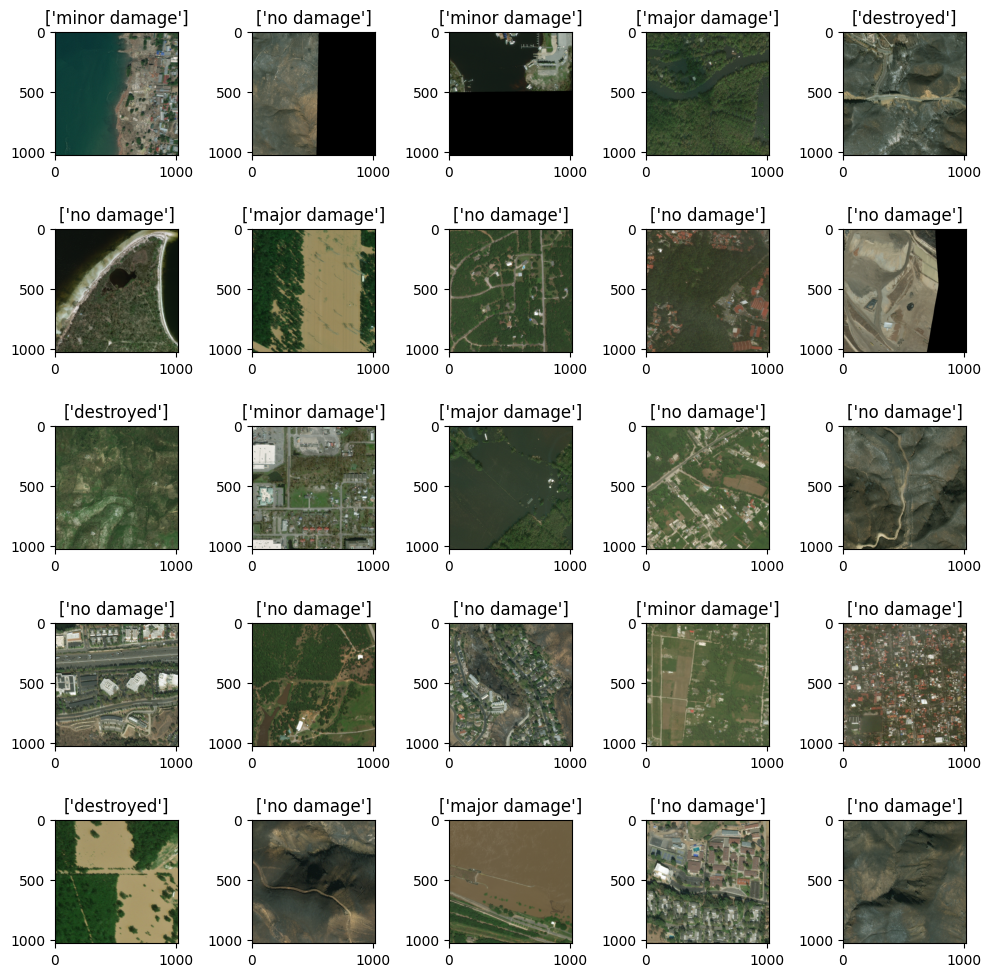

In [15]:
# Plot a few training images with labels
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    choice = random.randint(0, train_datasize-1)
    plt.title(get_label_from_one_hot(train_Y[choice]))
    plt.imshow(train_X[choice])

plt.tight_layout()
plt.show()

In [16]:
# Build the DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the base model

29084464/29084464 [==============================] - 0s 0us/step


In [17]:
model = Sequential([
  base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(len(class_names), activation='softmax')
])

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 32, 32, 1024)      7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 7300932 (27.85 MB)
Trainable params: 263428 (1.00 MB)
Non-trainable params: 7037504 (26.85 MB)
_____________

In [19]:
# Train the model
epochs = 10
batch_size = 16
history = model.fit(
  train_X,
  train_Y,
  validation_data=(test_X, test_Y),
  epochs=epochs,
  batch_size=batch_size
)

Epoch 1/10
94/94 [==============================] - 813s 9s/step - loss: 1.3647 - accuracy: 0.5140 - val_loss: 0.9807 - val_accuracy: 0.6140
Epoch 2/10
94/94 [==============================] - 831s 9s/step - loss: 1.0238 - accuracy: 0.5913 - val_loss: 0.9160 - val_accuracy: 0.6480
Epoch 3/10
94/94 [==============================] - 853s 9s/step - loss: 0.9741 - accuracy: 0.6060 - val_loss: 0.8984 - val_accuracy: 0.6460
Epoch 4/10
94/94 [==============================] - 851s 9s/step - loss: 0.9558 - accuracy: 0.6187 - val_loss: 0.8990 - val_accuracy: 0.6740
Epoch 5/10
94/94 [==============================] - 846s 9s/step - loss: 0.9058 - accuracy: 0.6413 - val_loss: 0.8870 - val_accuracy: 0.6620
Epoch 6/10
94/94 [==============================] - 840s 9s/step - loss: 0.8849 - accuracy: 0.6473 - val_loss: 0.8509 - val_accuracy: 0.6660
Epoch 7/10
94/94 [==============================] - 850s 9s/step - loss: 0.8806 - accuracy: 0.6460 - val_loss: 0.8473 - val_accuracy: 0.6780
Epoch 8/10
94

In [20]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 5))

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

Text(0.5, 1.0, 'Training and Validation Accuracy')

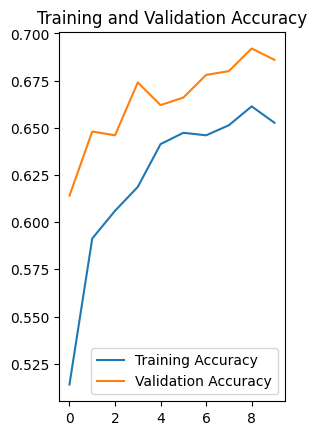

In [21]:
# Training and validation accuracy graph
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

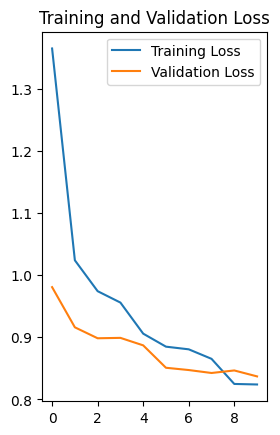

In [22]:
# Training and validation loss graph
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [23]:
# Evaluate the model on the test dataset
print("\nEvaluating model on test data:")
test_loss, test_acc = model.evaluate(test_X, test_Y, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")


Evaluating model on test data:
16/16 - 207s - loss: 0.8370 - accuracy: 0.6860 - 207s/epoch - 13s/step
Test Accuracy: 0.6860


In [24]:
# Predict on the test dataset
test_predictions = model.predict(test_X)
test_pred_labels = np.argmax(test_predictions, axis=1)
true_test_labels = np.argmax(test_Y, axis=1)

16/16 [==============================] - 214s 13s/step


In [25]:
# Accuracy Score
accuracy = accuracy_score(true_test_labels, test_pred_labels)
print(f"\nAccuracy on test data: {accuracy:.4f}")


Accuracy on test data: 0.6860


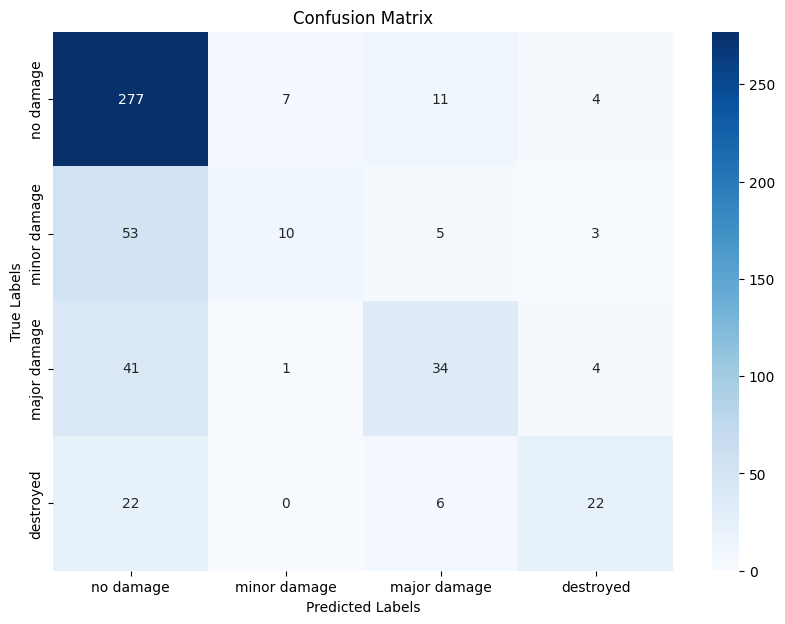

In [26]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_test_labels, test_pred_labels)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [27]:
# Classification Report
report = classification_report(true_test_labels, test_pred_labels, target_names=class_names)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

   no damage       0.70      0.93      0.80       299
minor damage       0.56      0.14      0.22        71
major damage       0.61      0.42      0.50        80
   destroyed       0.67      0.44      0.53        50

    accuracy                           0.69       500
   macro avg       0.63      0.48      0.51       500
weighted avg       0.66      0.69      0.64       500



In [28]:
# Save the model
model.save("regional-damage-classification-model")

In [29]:
# Gradio Interface for Inference
def disaster_classification(img):
    # Resize the image to the input size expected by the model
    img_resized = np.array(Image.fromarray(img).resize((img_height, img_width)))

    # Normalize the image (1./255 scaling as used in the model's preprocessing layer)
    img_resized = img_resized / 255.0

    # Prepare the image for prediction
    image = np.zeros((1, img_height, img_width, 3), dtype=np.float32)
    image[0] = img_resized

    # Make prediction using the model
    prediction = model.predict(image).tolist()[0]

    # Return a dictionary with class names and their predicted probabilities
    return {class_names[i]: prediction[i] for i in range(len(class_names))}

# Define Gradio interface
iface = gr.Interface(
    fn=disaster_classification,
    inputs=gr.Image(image_mode='RGB', type='numpy'),
    outputs=gr.Label(),
    title="Disaster Damage Classification",
    description="Upload an image to classify the extent of disaster damage."
)

# Launch the interface
iface.launch(share=True, show_error=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://3044f304c2e4bbf879.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 2s 2s/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3044f304c2e4bbf879.gradio.live


In [ ]:
## Below code is for the disater affected place highlighting functionality according to the labels (OPTIONAL CODE)##

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image, ImageDraw, ImageFile
import tensorflow as tf
import json
import glob
import random
import pathlib
import seaborn as sns
from shapely import wkt  # For handling WKT polygons

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet121

import gradio as gr
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [45]:
# Paths to the dataset
dataset_path = "/content/train"
train_data_dir = pathlib.Path(dataset_path + "/images")
label_data_dir = pathlib.Path(dataset_path + "/labels")  # Labels folder path

In [46]:
# Image dimensions
img_height = 1024
img_width = 1024
class_names = np.array(['no damage', 'minor damage', 'major damage', 'destroyed'])

In [47]:
# Function to load label file based on the image filename (passing as parameter)
def load_label_file(image_filename):
    label_filename = image_filename.replace('.png', '.json')  # Map to label JSON
    label_filepath = os.path.join(label_data_dir, os.path.basename(label_filename))

    with open(label_filepath, 'r') as f:
        disaster_data = json.load(f)

    return disaster_data

In [48]:
# Function to extract building polygons and damage levels from the label file (JSON data)
def extract_building_data(disaster_data):
    building_data = []

    for building in disaster_data["features"]["xy"]:
        polygon = wkt.loads(building["wkt"])  # Load polygon from WKT format
        damage_level = building["properties"]["subtype"]  # Get damage level
        building_data.append((polygon, damage_level))

    return building_data

In [49]:

# Function to highlight buildings on the image based on damage levels
def highlight_affected_areas(image, building_data):
    draw = ImageDraw.Draw(image)

    for polygon, damage_level in building_data:
        # Get the exterior coordinates of the polygon
        coords = [(x, y) for x, y in polygon.exterior.coords]

        # Choose color based on damage level
        if damage_level == "no-damage":
            color = "green"
        elif damage_level == "minor-damage":
            color = "yellow"
        elif damage_level == "major-damage":
            color = "orange"
        else:  # destroyed
            color = "red"

        # Draw polygon on image
        draw.polygon(coords, outline=color, width=3)

    return image

In [50]:
# Build the DenseNet121 model for damage classification
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the base model

model = Sequential([
  base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(len(class_names), activation='softmax')
])


In [51]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
# Gradio Interface for Inference and Highlighting Affected Buildings
def disaster_classification_and_highlighting(img, image_filename):
    # Resize the image for classification
    img_resized = np.array(Image.fromarray(img).resize((img_height, img_width)))

    # Normalize the image
    img_resized = img_resized / 255.0

    # Prepare the image for prediction
    image = np.zeros((1, img_height, img_width, 3), dtype=np.float32)
    image[0] = img_resized

    # Make prediction using the DenseNet model for classification
    prediction = model.predict(image).tolist()[0]

    # Use the provided filename (from user input or pre-processing)
    disaster_data = load_label_file(image_filename)

    # Extract building data and highlight affected areas based on the JSON data
    pil_img = Image.fromarray(img)
    building_data = extract_building_data(disaster_data)
    highlighted_img = highlight_affected_areas(pil_img, building_data)

    # Return classification results and the highlighted image
    classification_result = {class_names[i]: prediction[i] for i in range(len(class_names))}

    return classification_result, highlighted_img

In [ ]:
# Gradio interface with image upload and filename input
iface = gr.Interface(
    fn=disaster_classification_and_highlighting,
    inputs=[
        gr.Image(image_mode='RGB', type='numpy'),  # Upload image
        gr.Textbox(label="Image Filename", placeholder="Enter the corresponding image filename e.g. guatemala-volcano_00000003_post_disaster.png")  # Take the filename input
    ],
    outputs=[gr.Label(), gr.Image(type="numpy")],
    title="Disaster Damage Classification with Building Highlighting",
    description="Upload an image and provide the corresponding filename to classify the extent of disaster damage and highlight affected buildings."
)

# Launch the interface
iface.launch(share=True, show_error=True, debug=True)